In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

## NOTES FROM ANDREW

- i'm using as the source data gabe's latest data filenamed ohe_data.csv

- part 1 is me removing the encodings from gabe's final encoded data, which I think is necessary or maybe just optional for the k-prototypes categorical processing (at least is reduces the feature count which should speed up modeling). I did this rather than go back to the previous data set just in case gabe had any final adjustments before his encodings
    - NOTE that I kept the wc_ (weather condition) features encoded because some of them have multiple weather conditions so they aren't completely separate. Not sure if there's a better way this could be handled.

- part 2 is the modeling portion. A 1,000 point dataset took maybe a minute or two to process. 10,000+ gets really long. I've got a function there to help plot an elbow curve plot. If we try clustering on a larger dataset I'm expecting we're going to be looking at processing overnight - maybe best to try and narrow things down on as small a dataset as possible before trying anything big. I honestly think if we're going for an elbow curve we're going to have to use only small subsets of data (10k rows or less) so I'd say we estimate as best we can from lower row counts and then try to scale up.
    - There may be some room to experiment in what features are selected for clustering, etc. I haven't gone that far yet.

# remove encodings

To be sure everyone is using the same data set, I'm going to reverse encodings here rather than use the previously unencoded data (in case any additional cleaning was necessary in order to encode)

In [2]:
# get one-hot-encoded csv
df_ohe = pd.read_csv('../data/ohe_data.csv')

In [3]:
# drop unneeded index
df_ohe.drop(columns='Unnamed: 0', inplace=True)

In [4]:
df_ohe.head(2)

,Severity,Start_Time,Start_Lat,Start_Lng,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,1,2016-02-08 00:37:08,40.10891,-83.09286,42.1,58.0,29.76,10.0,10.4,0.00,...,0,0,0,0,0,0,0,0,0,0
1,0,2016-02-08 05:56:20,39.86542,-84.06280,36.9,91.0,29.68,10.0,0.0,0.02,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# all columns with a '_' in them
print([c for c in df_ohe.columns if '_' in c])

['Start_Time', 'Start_Lat', 'Start_Lng', 'Wind_Speed(mph)', 'Give_Way', 'No_Exit', 'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset', 'wc_clouds', 'wc_dust', 'wc_fair', 'wc_fog', 'wc_ice', 'wc_rain', 'wc_snow', 'wc_thunder', 'wc_wind', 'st_interstate', 'st_highway', 'st_other', 'State_AL', 'State_AR', 'State_AZ', 'State_CA', 'State_CO', 'State_CT', 'State_DC', 'State_DE', 'State_FL', 'State_GA', 'State_IA', 'State_ID', 'State_IL', 'State_IN', 'State_KS', 'State_KY', 'State_LA', 'State_MA', 'State_MD', 'State_ME', 'State_MI', 'State_MN', 'State_MO', 'State_MS', 'State_MT', 'State_NC', 'State_ND', 'State_NE', 'State_NH', 'State_NJ', 'State_NM', 'State_NV', 'State_NY', 'State_OH', 'State_OK', 'State_OR', 'State_PA', 'State_RI', 'State_SC', 'State_SD', 'State_TN', 'State_TX', 'State_UT', 'State_VA', 'State_VT', 'State_WA', 'State_WI', 'State_WV', 'State_WY', 'Side_L', 'Side_R', 'Timezone_US/Central', 'Timezone_US/Eastern', 'Timezone_US/Mountain', 'Timezone_US/Pacific', 'year_2016', 'ye

In [6]:
# note that wc (weather condition) encodings may have duplicates due to multiple
# specified weather conditions. Not sure whether to categorize these or leave them encoded,
# so leaving encoded for now.

# The rest of these should have one value per category per row

# The follow makes a list of currently encoded category prefixes towards eventually un-encoding them
encoded_cprefixes = ['st', 'State', 'Side', 'Timezone', 'year', 'month', 'hour']
encoded_vals = {k: list() for k in encoded_cprefixes}

for prefix in encoded_cprefixes:
    encoded_vals[prefix] = [c.split('_')[1] for c in df_ohe.columns if c.startswith(prefix + '_')]

print(encoded_vals)

{'st': ['interstate', 'highway', 'other'], 'State': ['AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], 'Side': ['L', 'R'], 'Timezone': ['US/Central', 'US/Eastern', 'US/Mountain', 'US/Pacific'], 'year': ['2016', '2017', '2018', '2019', '2020', '2021'], 'month': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], 'hour': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']}


In [7]:
# create unencoded tables for each encoded prefix
unencoded_dfs = {k: None for k in encoded_cprefixes}

for prefix in encoded_vals:
    cnames = [prefix + '_' + v for v in encoded_vals[prefix]]
    unencoded_dfs[prefix] = df_ohe[cnames].idxmax(axis=1).apply(lambda x: x.split('_')[1])

In [8]:
# create unencoded columns dataframe
df_unenc = pd.concat(unencoded_dfs.values(), keys=unencoded_dfs.keys(), axis=1)
print(df_unenc.shape)
df_unenc.head()

(2731050, 7)


,st,State,Side,Timezone,year,month,hour
0,other,OH,R,US/Eastern,2016,2,0
1,interstate,OH,R,US/Eastern,2016,2,5
2,interstate,OH,R,US/Eastern,2016,2,6
3,interstate,OH,R,US/Eastern,2016,2,6
4,interstate,OH,R,US/Eastern,2016,2,7


In [9]:
# create new dataframe dropping old encodings and using new unencoded columns
encoded_cnames = [p + '_' + v for p in encoded_vals for v in encoded_vals[p]]
df = pd.concat([df_ohe.drop(columns=encoded_cnames), df_unenc], axis=1)
df.head()

,Severity,Start_Time,Start_Lat,Start_Lng,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),...,wc_thunder,wc_wind,day,st,State,Side,Timezone,year,month,hour
0,1,2016-02-08 00:37:08,40.108910,-83.092860,42.1,58.0,29.76,10.0,10.4,0.00,...,0,0,8,other,OH,R,US/Eastern,2016,2,0
1,0,2016-02-08 05:56:20,39.865420,-84.062800,36.9,91.0,29.68,10.0,0.0,0.02,...,0,0,8,interstate,OH,R,US/Eastern,2016,2,5
2,0,2016-02-08 06:15:39,39.102660,-84.524680,36.0,97.0,29.70,10.0,0.0,0.02,...,0,0,8,interstate,OH,R,US/Eastern,2016,2,6
3,0,2016-02-08 06:51:45,41.062130,-81.537840,39.0,55.0,29.65,10.0,0.0,0.00,...,0,0,8,interstate,OH,R,US/Eastern,2016,2,6
4,1,2016-02-08 07:53:43,39.172393,-84.492792,37.0,93.0,29.69,10.0,10.4,0.01,...,0,0,8,interstate,OH,R,US/Eastern,2016,2,7


**NOTE** We might have to numericize the non-numeric categorical columns in order to later do interpretation. Some of the columns could be ordered even though they're not strictly numeric, which could make a mean interpretable. See below for how I'm running the interpretation on the categorization via a groupby. This generally should be easy for some columns (timezone could be 1-4 west to east, st (street type) could be 1-3 slowest to fastest, etc), not so much for others (e.g. state).

In [10]:
# I'll save this for easier recall later on
df.to_csv('../data/unencoded-ohe_data.csv', index=False)

In [11]:
# assuming all looks good, save memory by removing old variables
del df_ohe
del df_unenc
del encoded_cnames
del encoded_cprefixes
del encoded_vals
del unencoded_dfs

# try some k-prototype modeling

In [12]:
# columns to drop
to_drop = ['Start_Time', 'Start_Lat', 'Start_Lng']

# numeric columns to use
num_cols = ['Temperature(F)',
            'Humidity(%)',
            'Pressure(in)',
            'Visibility(mi)',
            'Wind_Speed(mph)',
            'Precipitation(in)'
           ]

# categorical columns to use
cat_cols = [c for c in df.drop(columns=to_drop).columns if c not in num_cols]

# show the columns
print(f'All columns: {df.columns}')
print(f'\nNumeric columns: {num_cols}')
print(f'\nCategorical columns: {cat_cols}')

All columns: Index(['Severity', 'Start_Time', 'Start_Lat', 'Start_Lng', 'Temperature(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset', 'wc_clouds',
       'wc_dust', 'wc_fair', 'wc_fog', 'wc_ice', 'wc_rain', 'wc_snow',
       'wc_thunder', 'wc_wind', 'day', 'st', 'State', 'Side', 'Timezone',
       'year', 'month', 'hour'],
      dtype='object')

Numeric columns: ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']

Categorical columns: ['Severity', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset', 'wc_clouds', 'wc_dust', 'wc_fair', 'wc_fog', 'wc_ice', 'wc_rain', 'wc_snow', 'wc_thunder'

In [13]:
# In order to properly cluster under k-prototypes we need to have a dataframe with
# (only) numeric columns scaled.

# instantiate standard scaler
ss = StandardScaler()
# fit/transform on numeric columns only
scaled_num_data = ss.fit_transform(df[num_cols])
# turn scaled data into new dataframe and combine with categorical
df_ss = pd.concat([pd.DataFrame(scaled_num_data, columns=num_cols), df[cat_cols]], axis=1)
# check it
df_ss.head()

,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Severity,Amenity,Bump,Crossing,...,wc_thunder,wc_wind,day,st,State,Side,Timezone,year,month,hour
0,-1.061058,-0.280072,0.273374,0.334319,0.576307,-0.080935,1,False,False,False,...,0,0,8,other,OH,R,US/Eastern,2016,2,0
1,-1.340930,1.163988,0.196244,0.334319,-1.293580,0.205979,0,False,False,False,...,0,0,8,interstate,OH,R,US/Eastern,2016,2,5
2,-1.389369,1.426545,0.215527,0.334319,-1.293580,0.205979,0,False,False,False,...,0,0,8,interstate,OH,R,US/Eastern,2016,2,6
3,-1.227905,-0.411350,0.167320,0.334319,-1.293580,-0.080935,0,False,False,False,...,0,0,8,interstate,OH,R,US/Eastern,2016,2,6
4,-1.335547,1.251507,0.205885,0.334319,0.576307,0.062522,1,False,False,False,...,0,0,8,interstate,OH,R,US/Eastern,2016,2,7


In [14]:
# ASIDE - I'll save this dataset too for easier recall later on
df_ss.to_csv('../data/kpm-data.csv', index=False)

In [15]:
# apparently we need column index numbers, not names... so get those first
col_ixs = [df_ss.columns.get_loc(cn) for cn in cat_cols]

# also I'm going to create a smaller test dataframe because this could take a while with the full one
small_df = df_ss.sample(1_000, random_state=1)
small_df.shape, small_df['Severity'].value_counts(normalize=True)

((1000, 37),
 0    0.906
 1    0.094
 Name: Severity, dtype: float64)

---------------
**NOTE** according to [one article](https://medium.com/analytics-vidhya/customer-segmentation-using-k-prototypes-algorithm-in-python-aad4acbaaede) the KPrototypes input has to be an array, not a dataframe...

In [16]:
# make an array out of a dataframe
small_array = small_df.values
small_array

array([[0.6020225003316857, -0.8051847775517763, 0.40835192476452414,
        ..., '2021', '6', '11'],
       [0.4297940580696254, -0.4988689925445656, 0.40835192476452414,
        ..., '2017', '6', '14'],
       [-0.04383415815103975, 1.2952663196405256, -1.0281972551080991,
        ..., '2020', '6', '3'],
       ...,
       [0.6020225003316857, 0.07000317961168279, 0.5144058910638484, ...,
        '2021', '9', '10'],
       [1.4631647116419864, -0.5426283904027386, 0.5240471607274211, ...,
        '2021', '9', '14'],
       [-2.304332462840579, 1.2952663196405256, -0.1412004460592319, ...,
        '2020', '2', '7']], dtype=object)

In [17]:
# and FINALLY run the model
# here I'm just running it once for example
kpm = KPrototypes(10, init='Huang', random_state=1, n_jobs=-1)
kpm.fit(small_array, categorical=col_ixs)

array([2, 2, 4, 8, 8, 9, 2, 4, 9, 9, 1, 4, 4, 4, 9, 4, 9, 1, 2, 4, 7, 7,
       7, 2, 7, 9, 2, 1, 4, 8, 8, 2, 1, 9, 3, 9, 9, 9, 9, 9, 8, 7, 9, 7,
       1, 1, 7, 4, 8, 1, 9, 9, 7, 9, 7, 2, 8, 1, 8, 9, 4, 6, 2, 2, 7, 1,
       8, 1, 2, 2, 7, 4, 9, 3, 3, 4, 9, 1, 9, 4, 9, 8, 9, 4, 8, 9, 9, 1,
       4, 8, 9, 8, 9, 9, 7, 2, 8, 1, 2, 9, 7, 4, 2, 2, 4, 9, 8, 4, 9, 9,
       8, 8, 3, 7, 1, 8, 2, 1, 0, 9, 3, 9, 7, 3, 3, 4, 8, 9, 9, 1, 4, 2,
       7, 4, 2, 9, 8, 8, 7, 4, 8, 9, 9, 2, 9, 7, 9, 7, 2, 8, 2, 1, 9, 7,
       2, 7, 3, 4, 9, 1, 3, 9, 4, 9, 7, 1, 2, 2, 9, 4, 7, 4, 2, 2, 7, 9,
       2, 9, 8, 4, 8, 2, 9, 2, 9, 7, 4, 8, 1, 2, 9, 8, 4, 9, 9, 4, 4, 9,
       9, 1, 7, 2, 9, 1, 9, 8, 2, 2, 9, 1, 2, 4, 9, 1, 8, 8, 8, 2, 2, 1,
       1, 2, 1, 2, 7, 2, 8, 2, 6, 4, 8, 2, 8, 4, 2, 9, 4, 8, 8, 2, 7, 4,
       9, 8, 8, 4, 3, 8, 2, 9, 9, 8, 1, 4, 1, 9, 2, 7, 3, 8, 4, 1, 8, 9,
       3, 8, 4, 7, 3, 6, 2, 4, 1, 8, 7, 8, 9, 9, 8, 7, 3, 8, 3, 9, 7, 9,
       2, 4, 1, 9, 7, 2, 4, 7, 4, 1, 9, 2, 8, 6, 2,

In [18]:
# Here's a function to get a bunch of scores at once in order to test for best
# cluster count. KPrototypes has a .cost_ attribute which is (apparently) a scoring value. 
# Not entirely sure I understand it but it's used for this purpose in the above article 
# so I'll use it here
def get_cost_range(data, cat_idx=[], start=5, end=10, skip=1, model_type='Huang', random_state=1):
    costs = list()
    for k in range(start, end+1, skip):
        kpm = KPrototypes(k, init=model_type, random_state=random_state, n_jobs=-1)
        kpm.fit(data, categorical=cat_idx)
        costs.append((k, kpm.cost_))
    
    return costs

In [19]:
# try it out on 10-13 clusters
costs = get_cost_range(small_array, col_ixs, 10, 13)
costs

[(10, 4997.888088405879),
 (11, 4808.328901347465),
 (12, 4770.363189496942),
 (13, 4657.7855346557635)]

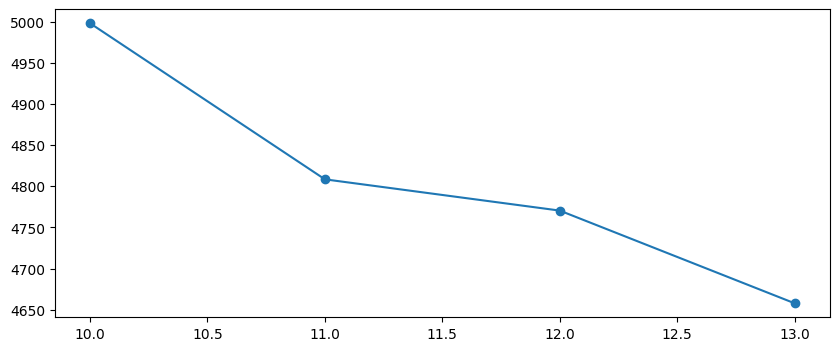

In [20]:
# plot the elbow curve (I think we need more points to really make sense of this)
cluster_nums, cost_list = zip(*costs)
fig, ax = plt.subplots(figsize=(10,4))
ax.scatter(cluster_nums, cost_list)
ax.plot(cluster_nums, cost_list);

In [21]:
# Attempt to interpret results
# I'll test results on the first kpm.fit_predict I ran a few cells above (before function)
result_df = small_df.copy()
# add cluster labels to dataframe
result_df['labels'] = kpm.labels_
# reverse scale numeric columns and replace in dataframe
result_df[num_cols] = pd.DataFrame(ss.inverse_transform(result_df[num_cols]), columns=num_cols).values

# group by category label
result_df.groupby('labels').agg(['median', 'mean', 'count']).T

/var/folders/xn/fd5qgltd59zbhpyb0q5439y40000gn/T/ipykernel_5311/1767299048.py:10: FutureWarning: ['Sunrise_Sunset', 'st', 'State', 'Side', 'Timezone'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  result_df.groupby('labels').agg(['median', 'mean', 'count']).T


labels                    0              1              2             3  \
Temperature(F) median  46.4   4.600000e+01   7.900000e+01  6.800000e+01   
               mean    46.4   4.365816e+01   7.807416e+01  6.431707e+01   
               count    1.0   9.800000e+01   1.780000e+02  4.100000e+01   
Humidity(%)    median  46.0   6.600000e+01   6.300000e+01  3.700000e+01   
               mean    46.0   6.557143e+01   6.335393e+01  4.056098e+01   
...                     ...            ...            ...           ...   
month          mean     1.0  1.148074e+151  3.746702e+227  2.713443e+49   
               count    1.0   9.800000e+01   1.780000e+02  4.100000e+01   
hour           median  16.0   1.300000e+01   1.450000e+01  1.500000e+01   
               mean    16.0  9.201441e+161            inf  4.075891e+71   
               count    1.0   9.800000e+01   1.780000e+02  4.100000e+01   

labels                             4      5             6              7  \
Temperature(F) median   6.700000e+01   68.0  2.750000e+01   5.000000e+01   
               mean     6.628249e+01   68.0  2.846154e+01   4.910769e+01   
               count    1.770000e+02    2.0  2.600000e+01   9.100000e+01   
Humidity(%)    median   8.100000e+01   96.5  8.450000e+01   9.300000e+01   
               mean     7.989831e+01   96.5  8.246154e+01   9.125275e+01   
...                              ...    ...           ...            ...   
month          mean    3.847515e+226   18.0  3.892736e+36  5.630891e+135   
               count    1.770000e+02    2.0  2.600000e+01   9.100000e+01   
hour           median   1.100000e+01   17.0  9.500000e+00   1.000000e+01   
               mean    2.147862e+272  908.0  7.636612e+36  1.144410e+135   
               count    1.770000e+02    2.0  2.600000e+01   9.100000e+01   

labels                             8              9  
Temperature(F) median   4.600000e+01   7.700000e+01  
               mean     4.371392e+01   7.554430e+01  
               count    1.580000e+02   2.280000e+02  
Humidity(%)    median   7.900000e+01   3.600000e+01  
               mean     7.536076e+01   3.569298e+01  
...                              ...            ...  
month          mean    2.609570e+241  9.322647e+297  
               count    1.580000e+02   2.280000e+02  
hour           median   1.000000e+01   1.500000e+01  
               mean    3.178621e+236            inf  
               count    1.580000e+02   2.280000e+02  

[96 rows x 10 columns]

Maybe there are other ways to display this to aid in interpretation. Need to go over lesson notes to see how interpretation was done in those cases.

**NOTES**
As of this writing, I haven't taken much time really trying to interpret the results. Intuitively I'm thinking that converting as many columns to numeric values might help, but maybe there's another way to get info from the model that I'm forgetting or unaware of. At very least, it looks like it works, but it might be too slow to be practical on a full data set so maybe using many smaller samples and averaging might give us something usable faster?